# KAGGLE STORE SALES FORECASTING
by Jamael Codaye <br>


In [63]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (9, 4)
plt.style.use("fivethirtyeight")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/arima-fits-forecasts/fits_2.csv
/kaggle/input/arima-fits-forecasts/fore_2.csv


In [64]:
df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", 
                 index_col=0,
                 parse_dates=True)

df.date = pd.to_datetime(df.date)
df.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


In [65]:
holidays_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
holidays_df.date = pd.to_datetime(holidays_df.date)
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Text(0.5, 1.0, 'Sales by Store')

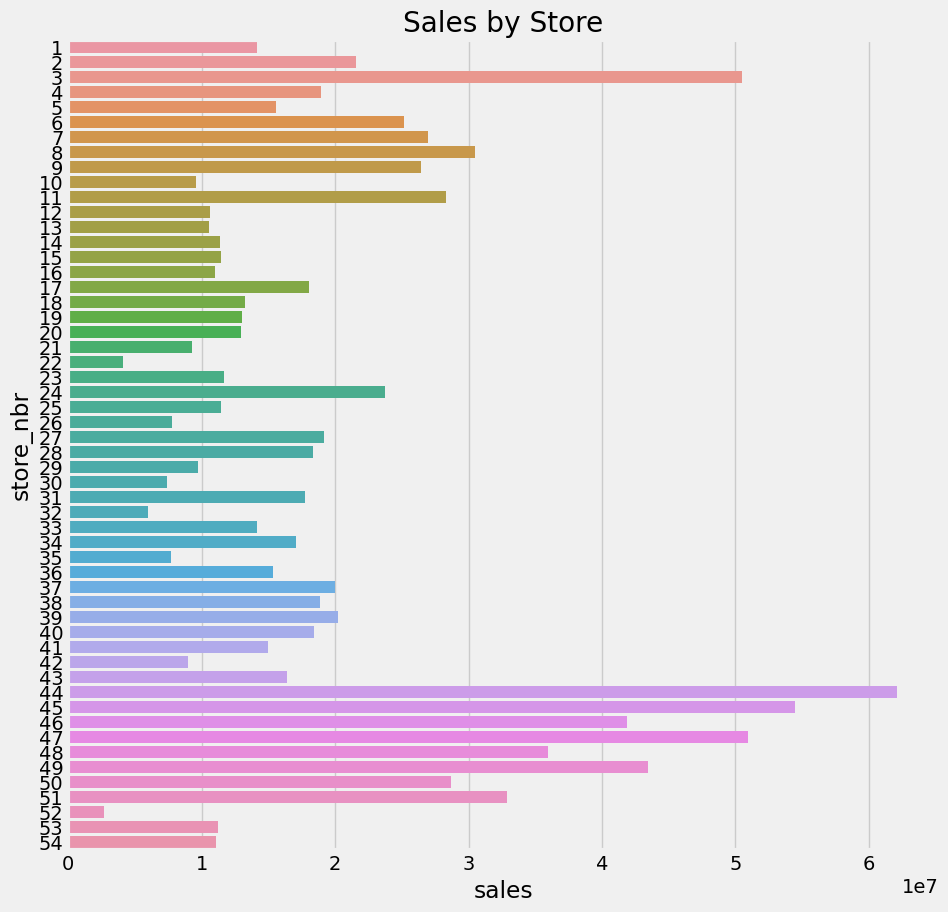

In [66]:
fig = plt.figure(figsize=(10,10))

sales = df.sales
sales_by_store = sales.groupby(df.store_nbr).sum().sort_values(ascending=False)
sns.barplot(y=sales_by_store.index, x=sales_by_store, orient="h")
plt.title("Sales by Store")

Text(0.5, 1.0, 'Sales by Product Category')

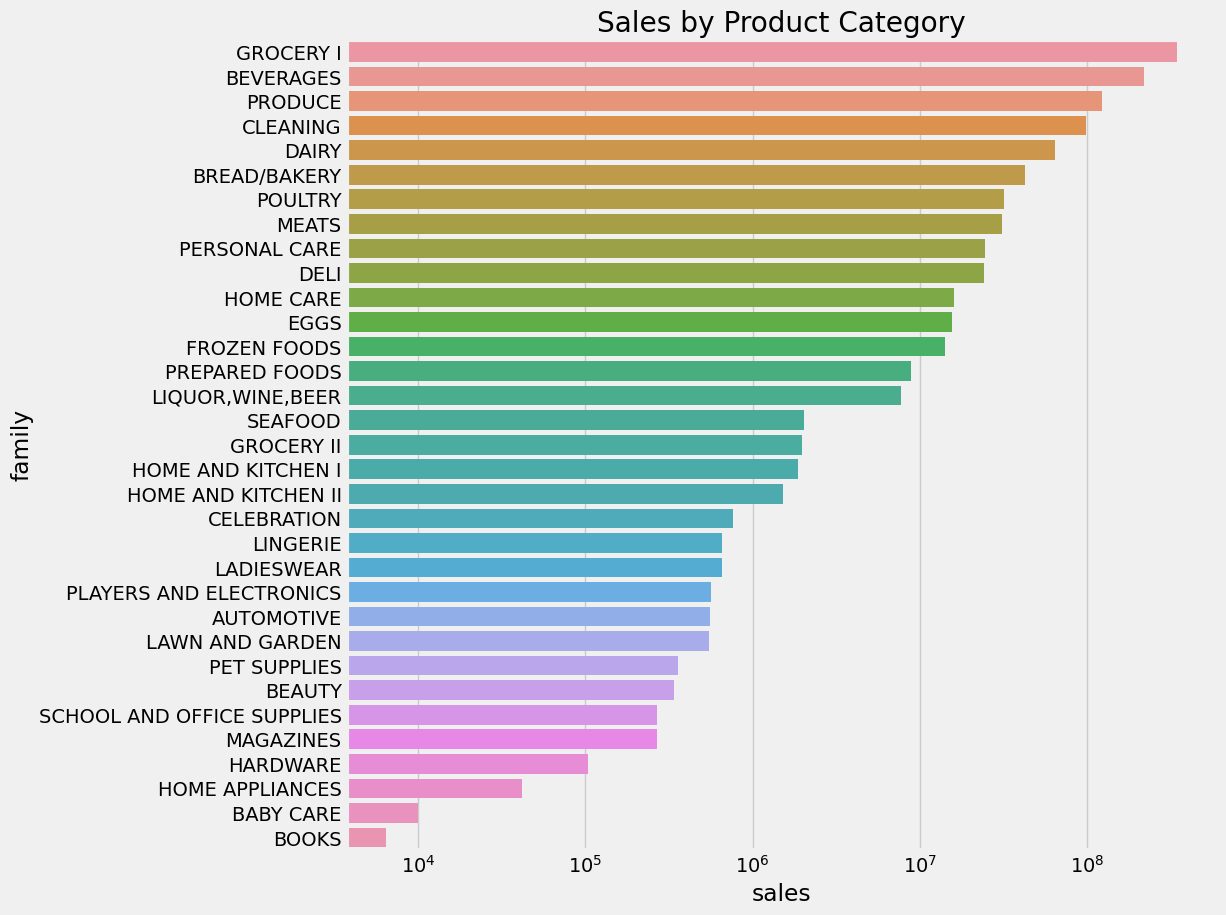

In [67]:
fig = plt.figure(figsize=(10,10))
sales_by_family = sales.groupby(df.family).sum().sort_values(ascending=False)
sns.barplot(y=sales_by_family.index, x=sales_by_family, orient="h")
plt.xscale("log")
plt.title("Sales by Product Category")

<Axes: xlabel='date', ylabel='sales'>

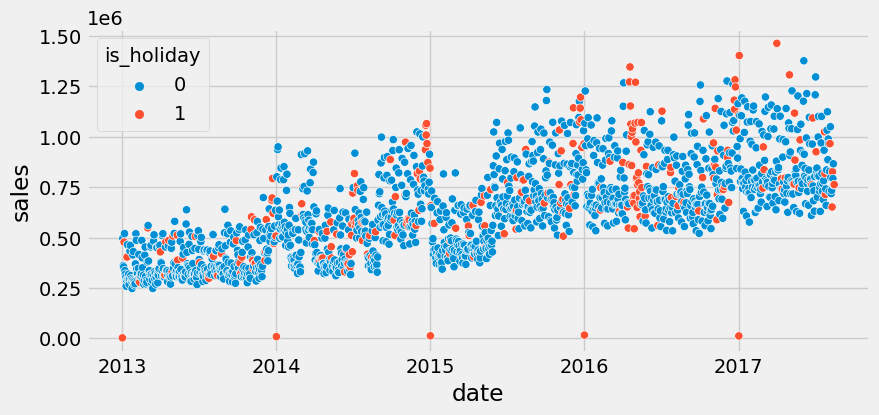

In [68]:
sales_by_day = sales.groupby(df.date).sum()

holiday_indicator = pd.DataFrame(np.zeros(len(sales_by_day)), index=sales_by_day.index)
temp_holidays_df = pd.DataFrame(np.ones(len(holidays_df)), index=holidays_df.date, columns=["is_holiday"])
temp_holidays_df["date_"] = temp_holidays_df.index
temp_holidays_df.drop_duplicates(subset="date_", inplace=True)

holiday_indicator = holiday_indicator.merge(temp_holidays_df, how="left", 
                                            left_on=holiday_indicator.index,
                                            right_on=temp_holidays_df.index)

holiday_indicator.is_holiday.fillna(0, inplace=True)
holiday_indicator.index = holiday_indicator.pop("key_0")


sns.scatterplot(x=sales_by_day.index, y=sales_by_day, hue=holiday_indicator.is_holiday,
               hue_order=[0, 1])

We see a roughly linear trend of the time series.

Text(0.5, 1.0, 'Mean Sales by the Day of Week')

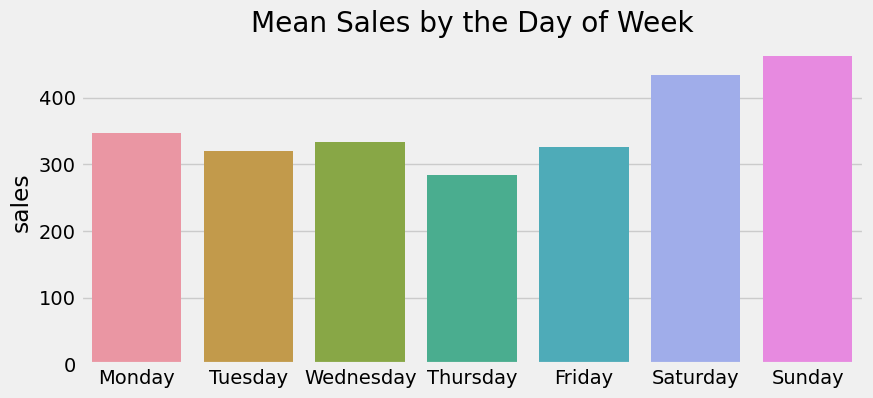

In [69]:
sales_by_week = sales.groupby(df.date.dt.dayofweek).mean()
sns.barplot(x=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           y=sales_by_week)
plt.title("Mean Sales by the Day of Week")

Saturday and Sundays are the days with the most sales wgukst Thursdays and Fridays are the days with the least.

Text(0.5, 1.0, 'Mean Sales by Month')

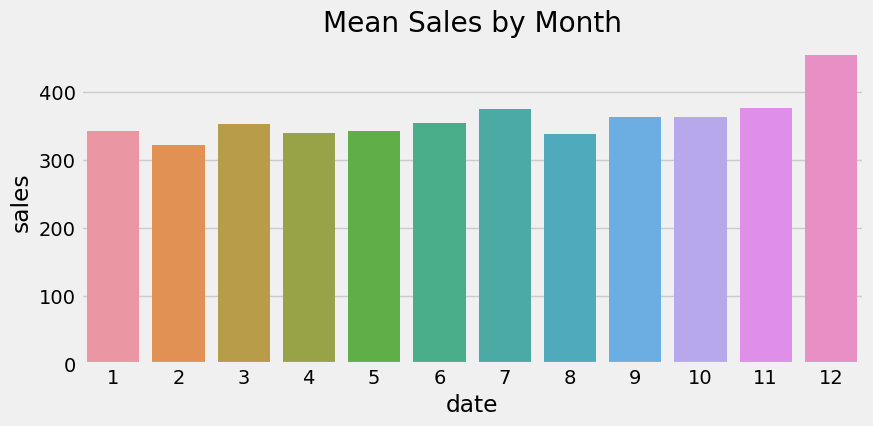

In [70]:
sales_by_month = sales.groupby(df.date.dt.month).mean()
sns.barplot(x=sales_by_month.index,
           y=sales_by_month)
plt.title("Mean Sales by Month")

The highest selling month is the month of december, the sales of the other months are fairly uniform.

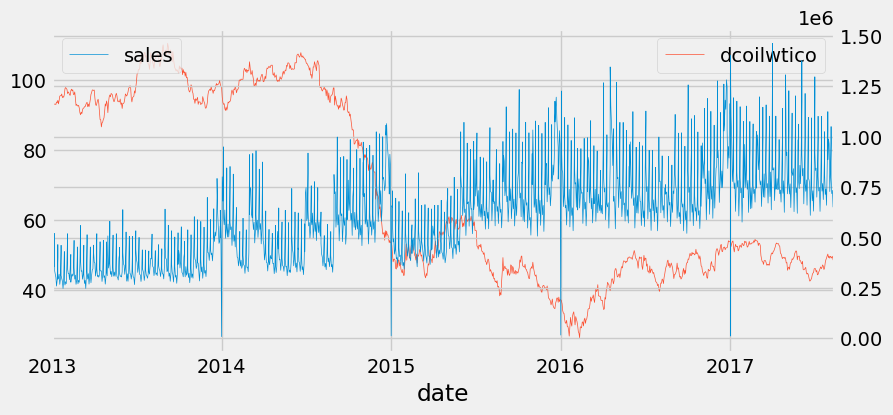

In [71]:
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
oil_df.index = pd.to_datetime(oil_df.date)
oil_df.pop("date")

oil_df = oil_df.ffill()
oil_df = oil_df.bfill()
ax = oil_df.plot(linewidth=0.5, color="C1")
ax2 = ax.twinx()
sales_by_day.plot(ax=ax2, linewidth=0.5, label="sales")
plt.legend()

We see no discernable relationship between sales and oil prices.

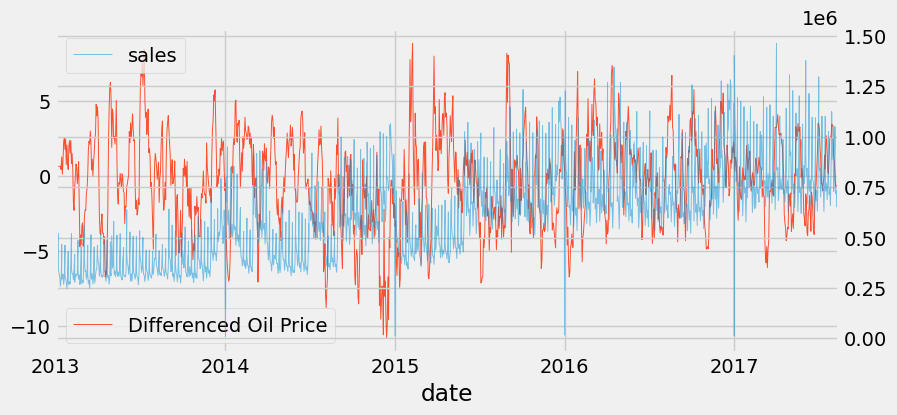

In [72]:
diff7 = oil_df.dcoilwtico - oil_df.dcoilwtico.shift(7)
diff7 = diff7.bfill()
ax = diff7.plot(linewidth=0.7, color="C1", label="Differenced Oil Price")
plt.legend()
ax2 = ax.twinx()
sales_by_day.plot(ax=ax2, linewidth=0.7, label="sales", alpha=0.5)
plt.legend()

In [73]:
transaction_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
transaction_df.date = pd.to_datetime(transaction_df.date)
transaction_df["identifier"] =  transaction_df.store_nbr.apply(str)+ "_" + transaction_df.date.apply(str)
transaction_df.head()

,date,store_nbr,transactions,identifier
0,2013-01-01,25,770,25_2013-01-01 00:00:00
1,2013-01-02,1,2111,1_2013-01-02 00:00:00
2,2013-01-02,2,2358,2_2013-01-02 00:00:00
3,2013-01-02,3,3487,3_2013-01-02 00:00:00
4,2013-01-02,4,1922,4_2013-01-02 00:00:00


In [74]:
identifiers = df.store_nbr.apply(str) + "_" + df.date.apply(str)
is_in = identifiers.isin(transaction_df.identifier)

In [75]:
is_in.index = identifiers
is_in_counts = is_in.groupby(is_in.index).sum()
is_in_counts[is_in_counts == 0]

10_2013-01-01 00:00:00    0
10_2013-06-19 00:00:00    0
10_2014-01-01 00:00:00    0
10_2015-01-01 00:00:00    0
10_2016-01-01 00:00:00    0
                         ..
9_2016-01-01 00:00:00     0
9_2016-01-02 00:00:00     0
9_2016-01-03 00:00:00     0
9_2016-01-04 00:00:00     0
9_2017-01-01 00:00:00     0
Length: 7448, dtype: int64

/tmp/ipykernel_32/3610509083.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groups = transaction_df.groupby("store_nbr").sum()


<Axes: ylabel='store_nbr'>

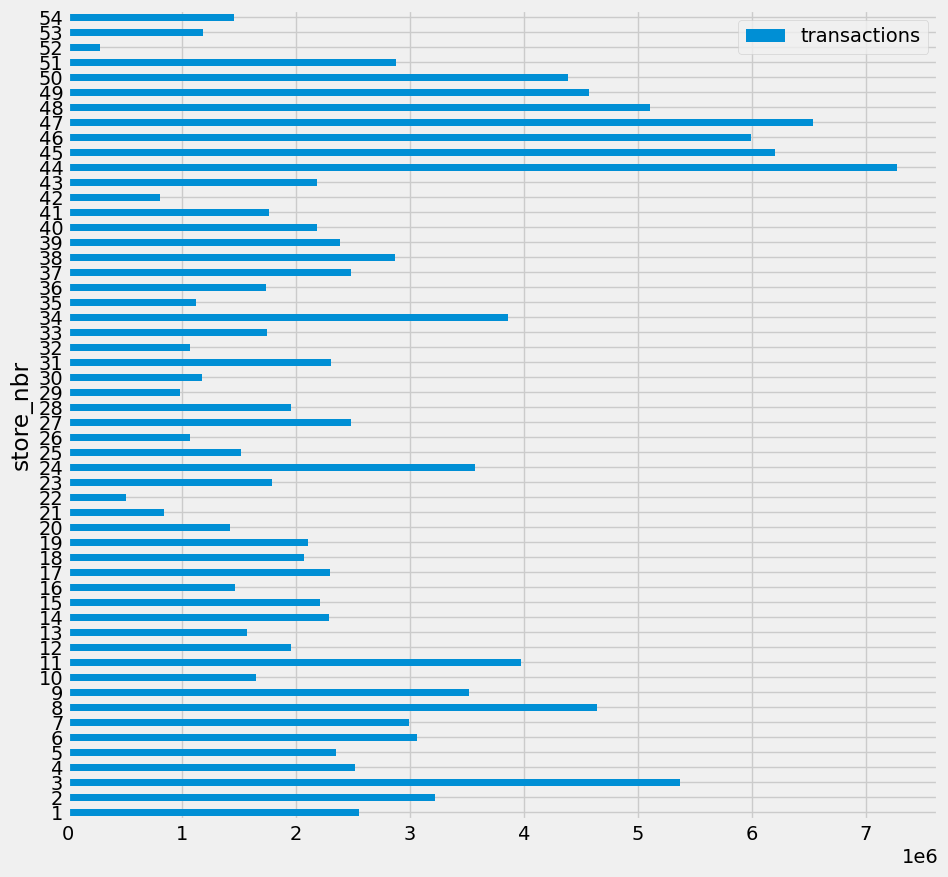

In [76]:
groups = transaction_df.groupby("store_nbr").sum()
groups.plot(kind="barh", figsize=(10, 10))

### MODELLING

In [77]:
df_groups = [(f"store_{_[0]}_{_[1]}", group) for (_, group) in df.groupby(["store_nbr", "family"])]

In [78]:
df_groups[0]

('store_1_AUTOMOTIVE',
               date  store_nbr      family  sales  onpromotion
 id                                                           
 0       2013-01-01          1  AUTOMOTIVE    0.0            0
 1782    2013-01-02          1  AUTOMOTIVE    2.0            0
 3564    2013-01-03          1  AUTOMOTIVE    3.0            0
 5346    2013-01-04          1  AUTOMOTIVE    3.0            0
 7128    2013-01-05          1  AUTOMOTIVE    5.0            0
 ...            ...        ...         ...    ...          ...
 2991978 2017-08-11          1  AUTOMOTIVE    1.0            0
 2993760 2017-08-12          1  AUTOMOTIVE    6.0            0
 2995542 2017-08-13          1  AUTOMOTIVE    1.0            0
 2997324 2017-08-14          1  AUTOMOTIVE    1.0            0
 2999106 2017-08-15          1  AUTOMOTIVE    4.0            0
 
 [1684 rows x 5 columns])

In [79]:
y_train = df.pop("sales")

In [80]:
df

,date,store_nbr,family,onpromotion
id,,,,
0,2013-01-01,1,AUTOMOTIVE,0
1,2013-01-01,1,BABY CARE,0
2,2013-01-01,1,BEAUTY,0
3,2013-01-01,1,BEVERAGES,0
4,2013-01-01,1,BOOKS,0
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,0
3000884,2017-08-15,9,PREPARED FOODS,1
3000885,2017-08-15,9,PRODUCE,148


In [81]:
def df_constructor(df, holidays, transaction_df, oil=None, holiday_feats=None):
    #holiday_feats
    if holiday_feats is None:
        holiday_feats = ["date", "type", "locale", "locale_name", "transferred"]
    holidays = holidays[holiday_feats]
    holidays = holidays.drop_duplicates(subset="date")
    
    res_df = df.merge(holidays, how="left", on="date")
    res_df = res_df.fillna("normal")
    res_df.transferred = res_df.transferred.apply(str)
    
    #transactions_df

    res_df["identifier"] = res_df.store_nbr.apply(str) + "_" + res_df.date.apply(str)
    transaction_df = transaction_df[["identifier", "transactions"]]
    
    res_df = res_df.merge(transaction_df, on="identifier", how="left")
    res_df.transactions = res_df.transactions.fillna(0)
    res_df.pop("identifier")
    
    return res_df

test_df = df_constructor(df, holidays=holidays_df, transaction_df=transaction_df)
test_df.head()

,date,store_nbr,family,onpromotion,type,locale,locale_name,transferred,transactions
0,2013-01-01,1,AUTOMOTIVE,0,Holiday,National,Ecuador,False,0.0
1,2013-01-01,1,BABY CARE,0,Holiday,National,Ecuador,False,0.0
2,2013-01-01,1,BEAUTY,0,Holiday,National,Ecuador,False,0.0
3,2013-01-01,1,BEVERAGES,0,Holiday,National,Ecuador,False,0.0
4,2013-01-01,1,BOOKS,0,Holiday,National,Ecuador,False,0.0


In [82]:
test_df.transferred.value_counts()

normal    2551824
False      433026
True        16038
Name: transferred, dtype: int64

In [83]:
test_df.isna().sum()

date            0
store_nbr       0
family          0
onpromotion     0
type            0
locale          0
locale_name     0
transferred     0
transactions    0
dtype: int64

In [84]:
from sklearn.preprocessing import OneHotEncoder
cat_feats = ["type", "locale", "locale_name", "transferred", "family"]

def encode_feats(df, fit_only=False):
    encoder = OneHotEncoder(sparse_output=False, drop="first")
    encoded = pd.DataFrame(encoder.fit_transform(df[cat_feats]),
                          index=df.index,
                          columns=encoder.get_feature_names_out())
    
    encoded["onpromotion"] = df.onpromotion
    
    trend = (df.date - df.date[0]).dt.days
    encoded["trend"] = trend
    encoded["transactions"] = df.transactions
    
    return encoded

test_df2 = encode_feats(test_df)
test_df2

,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,type_normal,locale_National,locale_Regional,locale_normal,locale_name_Cayambe,...,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,onpromotion,trend,transactions
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1687,2155.0
3000884,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1687,2155.0
3000885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,148,1687,2155.0
3000886,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8,1687,2155.0


<Axes: >

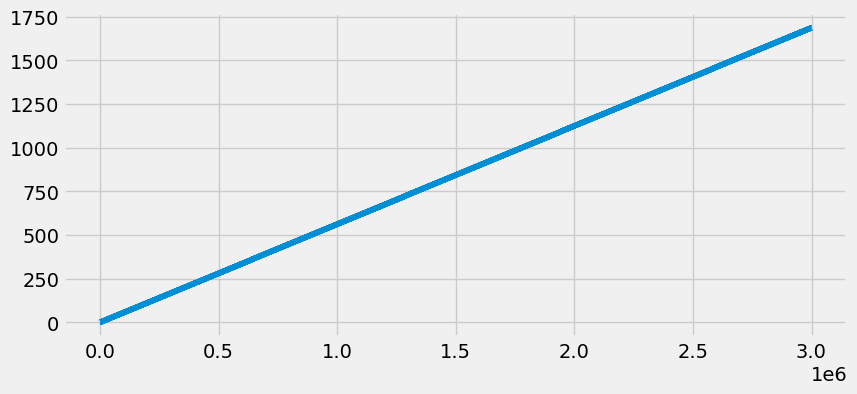

In [85]:
test_df2.trend.plot()

In [86]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

class Model():
    
    def __init__(self):
        self.model_dict1 = {}
        self.model_dict2 = {}
        self.feats_dict = {}
        self.encoder = None
        self.df_ = None
        self.start_date = None
    
    def fit(self, df, holidays, transaction_df, y):
        self.start_date = df.date[0]
        
        df_ = self.df_constructor(df, holidays, transaction_df=transaction_df)
        df_ = self.encode_feats(df_, fit_only=True)
        self.df_ = df_
        
        df_groups = self.group_df(df, df_)
        
        for label, group in df_groups:
            group = group.drop(["store_nbr", "family"], axis=1)
            group_sum = group.sum()
            
            self.feats_dict[label] = group_sum.index[group_sum != 0]
            
            model_1 = LinearRegression()
            model_1.fit(group[self.feats_dict[label]], y.loc[group.index])
            
            preds = pd.Series(model_1.predict(group[self.feats_dict[label]])).apply(self.max_f).to_numpy()
            
            resid = y.loc[group.index] - preds
            
            model_2 = XGBRegressor(n_estimators=50, max_depth=5)
            model_2.fit(group[self.feats_dict[label]], resid)
            
            self.model_dict1[label] = model_1
            self.model_dict2[label] = model_2
        
        return self
    
    def predict(self, df, holidays, transaction_df):

        df_ = self.df_constructor(df, holidays, transaction_df=transaction_df)
        df_ = self.encode_feats(df_)
        
        df_groups = self.group_df(df, df_)
        
        preds = []
        idx = []
        
        for label, group in df_groups:
            group = group.drop(["store_nbr", "family"], axis=1)
            
            pred_ = self.model_dict1[label].predict(group[self.feats_dict[label]])
            pred_ = pd.Series(pred_).apply(self.max_f).to_numpy() + self.model_dict2[label].predict(group[self.feats_dict[label]])

            preds.extend(pred_)
            idx.extend(group.index)
            
        res = pd.Series(preds, index=idx)
        res = res.sort_index()
        res = res.apply(self.max_f)
        
        return res
    
    def max_f(self, x):
        return max(0.0, x)
    
    def group_df(self, df, df_):
        df_["store_nbr"] = df.store_nbr
        df_["family"] = df.family
        
        df_groups = [(f"store_{label[0]}_{label[1]}",group) for (label, group) in df_.groupby(["store_nbr", "family"])]
       
        return df_groups
    
    
    def encode_feats(self, df, fit_only=False, cat_feats=None):
        df_ = pd.DataFrame(df[["type", "locale", "locale_name", "transferred"]])
        df_ = self.add_synthetic_feats(df, df_)
        
        if cat_feats is None:
            cat_feats = ["type", "locale", "locale_name", "transferred",
                        "day", "month", "day_of_month"]
        
        if fit_only:
            self.encoder = OneHotEncoder(sparse_output=False, drop="first")
            self.encoder = self.encoder.fit(df_[cat_feats])
            
        df_ = pd.DataFrame(self.encoder.transform(df_[cat_feats]),
                              index=df.index,
                              columns=self.encoder.get_feature_names_out())
        
        df_["transactions"] = df.transactions
        df_["onpromotion"] = df.onpromotion
        
        trend = (df.date - self.start_date).dt.days
        df_["trend"] = trend
        
        date_range = pd.date_range(start="2016-04-16", freq="D", periods=30)
        quake_indicator = df.date.isin(date_range)
        df_["quake_indicator"] = quake_indicator
        
        df_.index = df.index
        
        return df_
    
    def add_synthetic_feats(self, df, df_):
        df_["day"] = df.date.dt.dayofweek
        df_["month"] = df.date.dt.month
        
        day_of_month = pd.Series(np.zeros(len(df)), index=df.index)
        idx = df.date.dt.day.isin([15, 16, 17, 18, 30, 31, 1, 2, 3])
        day_of_month[idx] = 1
        df_["day_of_month"] = day_of_month
        
        df_.index = df.index
        
        return df_
    
    def df_constructor(self, df, holidays, transaction_df, oil=None, holiday_feats=None):
        #Holiday feats
        if holiday_feats is None:
            holiday_feats = ["date", "type", "locale", "locale_name", "transferred"]
            
        holidays = holidays[holiday_feats]
        holidays = holidays.drop_duplicates(subset="date")

        res_df = df.merge(holidays, how="left", on="date")
        res_df = res_df.fillna("normal")
        res_df.transferred = res_df.transferred.apply(str)
        
        #transaction_df
        res_df["identifier"] = res_df.store_nbr.apply("str") + "_" + res_df.date.apply(str)
        transaction_df = transaction_df[["identifier", "transactions"]]
        
        res_df = res_df.merge(transaction_df, on="identifier", how="left")
        res_df.transactions = res_df.transactions.fillna(0)
        res_df.pop("identifier")
        
        res_df.index = df.index
        
        return res_df

In [87]:
%%time
model = Model()
model.fit(df, holidays_df, transaction_df, y_train)

CPU times: user 27min 44s, sys: 5min 54s, total: 33min 38s
Wall time: 9min 9s


In [88]:
with pd.option_context("display.max_columns", None):
    display(model.df_)

,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,type_normal,locale_National,locale_Regional,locale_normal,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo de los Tsachilas,locale_name_normal,transferred_True,transferred_normal,day_1,day_2,day_3,day_4,day_5,day_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_month_1.0,transactions,onpromotion,trend,quake_indicator,store_nbr,family
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,False,1,AUTOMOTIVE
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,False,1,BABY CARE
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,False,1,BEAUTY
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,False,1,BEVERAGES
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,False,1,BOOKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1687,False,9,POULTRY
3000884,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1687,False,9,PREPARED FOODS
3000885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,148,1687,False,9,PRODUCE


In [89]:
%%time
fits1 = model.predict(df, holidays_df, transaction_df)

CPU times: user 4min 14s, sys: 1min 43s, total: 5min 58s
Wall time: 1min 59s


In [177]:
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae

def print_metrics(y, fits):
    msle_ = msle(y_train, fits)
    mae_ = mae(y_train, fits)
    
    df_res = pd.DataFrame([msle_, mae_], index=["MSLE", "MAE"])
    df_res.columns = ["metrics"]
    
    return df_res

metrics1 = print_metrics(y_train, fits1)
metrics1

,metrics
MSLE,0.290016
MAE,29.885583


In [91]:
fits1.describe()

count    3.000888e+06
mean     3.582531e+02
std      1.087428e+03
min      0.000000e+00
25%      4.945077e-01
50%      1.232902e+01
75%      1.986286e+02
max      1.218103e+05
dtype: float64

In [92]:
y_train.describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

## Test Predictions

In [93]:
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", index_col=0)
test.date = pd.to_datetime(test.date)

forecasts1 = model.predict(test, holidays_df, transaction_df)
forecasts1

3000888    2.140313e+00
3000889    9.107392e-09
3000890    8.708403e+00
3000891    2.356196e+03
3000892    6.813449e-02
               ...     
3029395    3.150311e+02
3029396    1.146902e+02
3029397    1.319533e+03
3029398    1.866771e+02
3029399    1.745019e+01
Length: 28512, dtype: float64

In [94]:
forecasts1.describe()

count    28512.000000
mean       450.701795
std       1206.565316
min          0.000000
25%          4.389787
50%         31.412263
75%        262.710310
max      14241.739528
dtype: float64

In [95]:
forecasts1_df = pd.DataFrame(forecasts1, index=forecasts1.index, columns=["sales"])
forecasts1_df.index.name = "id"
forecasts1_df.head()

,sales
id,
3000888,2.140313e+00
3000889,9.107392e-09
3000890,8.708403e+00
3000891,2.356196e+03
3000892,6.813449e-02


In [179]:
forecasts1_df.to_csv("model1.csv")

## Autoregressive model

Text(0.5, 1.0, 'store_1_AUTOMOTIVE')

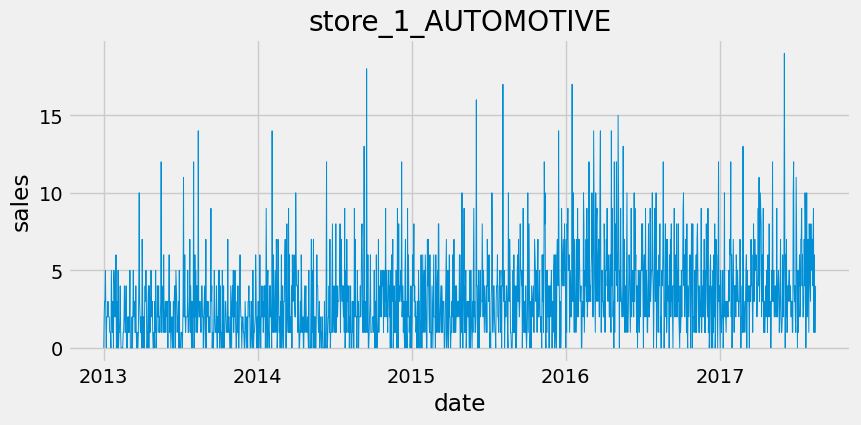

In [96]:
df_0 = df_groups[0][1].copy()
sales_0 = y_train[df_0.index]
df_0["sales"] = sales_0
sns.lineplot(x=df_0.date, y=df_0.sales, linewidth=0.7)
plt.title(df_groups[0][0])

In [97]:
import statsmodels.api as sm

sales_0 = df_0.sales

In [98]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

def test_stationarity(ts, lags=None):
    fig = plt.figure(figsize=(10, 8))
    
    fig.add_subplot(211)
    plt.plot(ts[12:], linewidth=0.6)
    plt.title("Series")
    
    fig.add_subplot(223)
    plot_acf(ts, lags=40, ax=plt.gca(), linewidth=0.6)
    
    fig.add_subplot(224)
    plot_pacf(ts, method="ywm", lags=40, ax=plt.gca(), linewidth=0.6)
    
    
    plt.tight_layout()
    
    kpss_res = kpss(ts)
    print("KPSS P_value: ", kpss_res[1])

/tmp/ipykernel_32/3991099147.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(ts)


KPSS P_value:  0.1


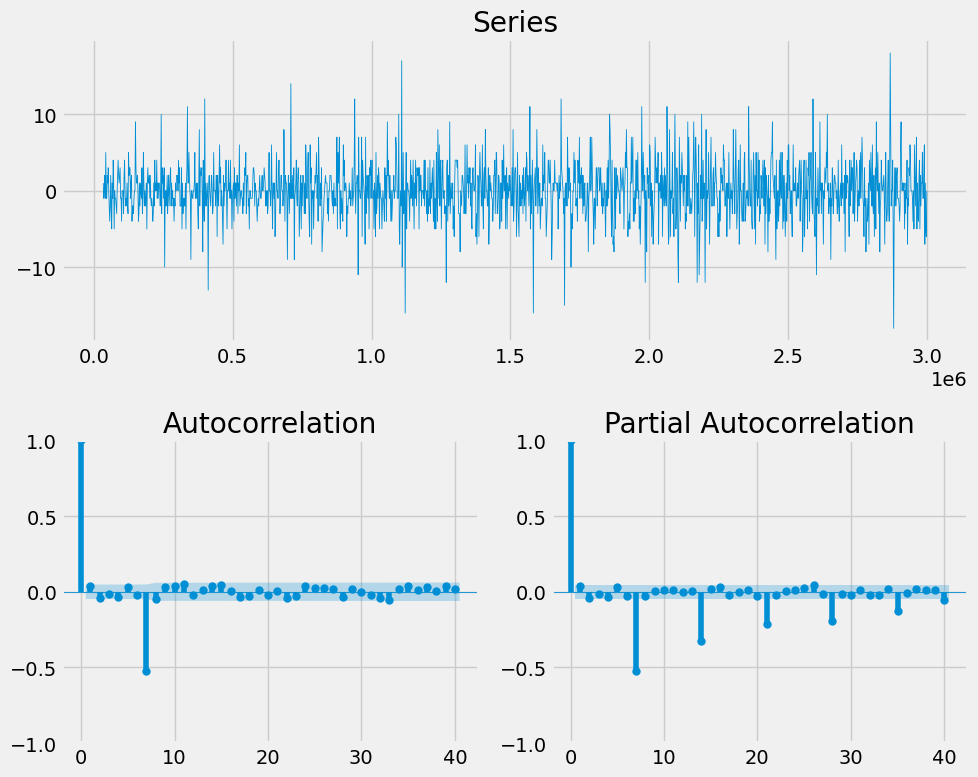

In [99]:
from statsmodels.tsa.statespace.tools import diff

diff_0_1 = diff(sales_0, k_diff=0, k_seasonal_diff=1, seasonal_periods=7)
test_stationarity(diff_0_1)


Either an MA(0) and seasonal MA(1) or an AR(0) and seasonal AR(5)

Text(0.5, 1.0, 'store_4_BABY CARE')

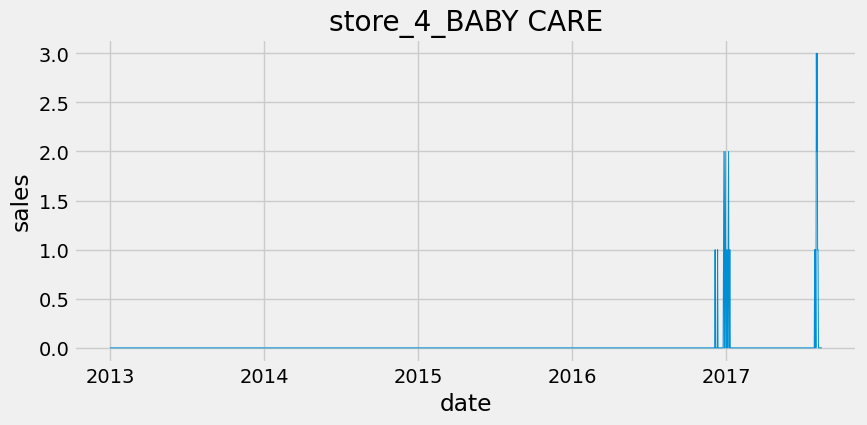

In [100]:
df_100 = df_groups[100][1].copy()
sales_100 = y_train[df_100.index]
df_100["sales"] = sales_100
sns.lineplot(x=df_100.date, y=df_100.sales, linewidth=0.7)
plt.title(df_groups[100][0])

Text(0.5, 1.0, 'store_31_EGGS')

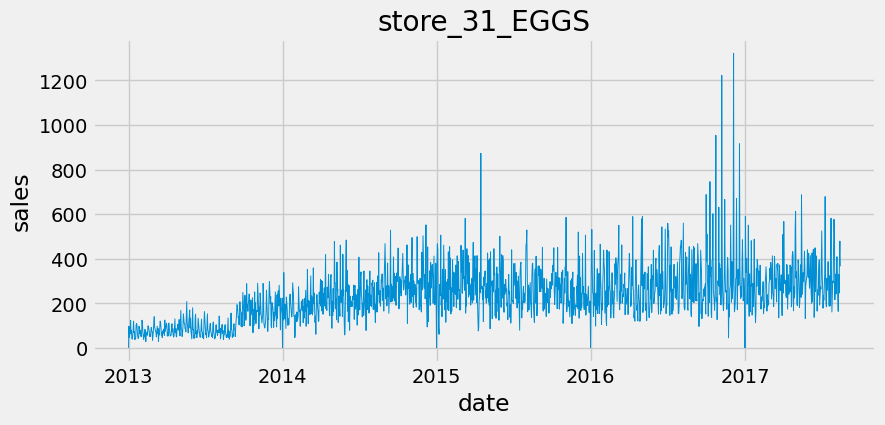

In [101]:
df_1000 = df_groups[1000][1].copy()
sales_1000 = y_train[df_1000.index]
df_1000["sales"] = sales_1000
sns.lineplot(x=df_1000.date, y=df_1000.sales, linewidth=0.7)
plt.title(df_groups[1000][0])

/tmp/ipykernel_32/3991099147.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(ts)


KPSS P_value:  0.1


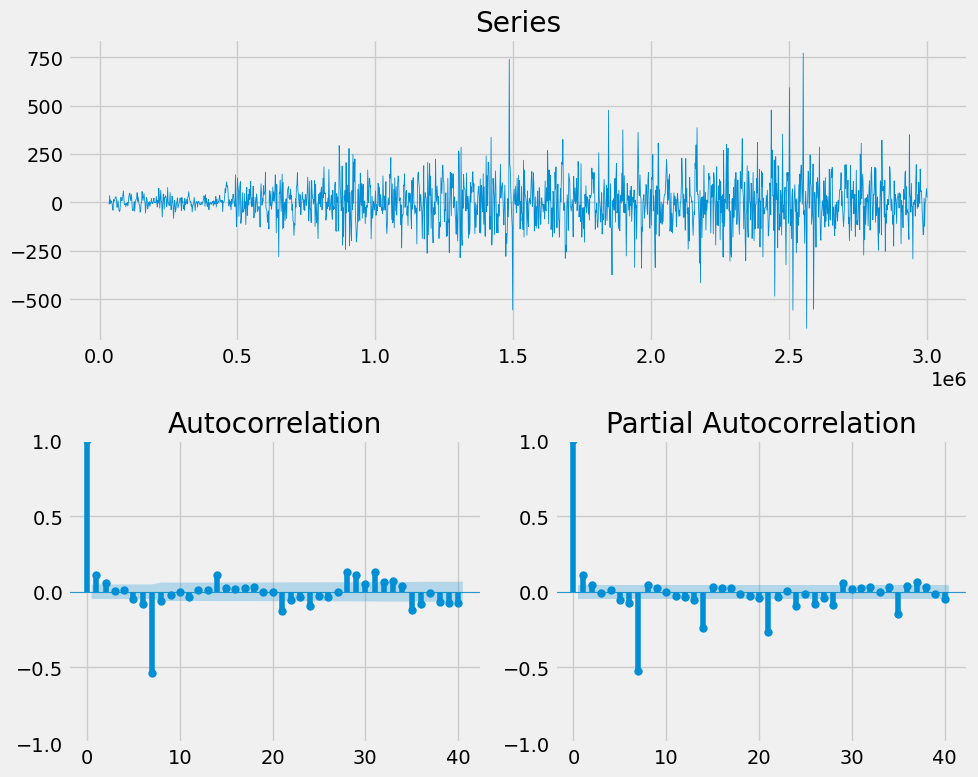

In [102]:
diff_0_1 = diff(sales_1000, k_diff=0, k_seasonal_diff=1, seasonal_periods=7)
test_stationarity(diff_0_1)

In [103]:
from statsmodels.tsa.arima.model import ARIMA

class ARModel():
    
    def __init__(self):
        self.model_dict = {}
        self.model_ids = []
    
    def fit_predict(self, df, y, df2):
        y_df = pd.DataFrame(y, columns=["sales"])
        y_df["store_nbr"] = df.store_nbr
        y_df["family"] = df.family
        y_df["onpromotion"] = df.onpromotion

        y_df["id"] = df.index
        y_df.index = pd.DatetimeIndex(df.date).to_period("D")
        
        y_groups = [(f"store_{label[0]}_family_{label[1]}", group) for label, group in y_df.groupby(["store_nbr", "family"])]
        pred_groups = dict(((f"store_{label[0]}_family_{label[1]}", group)) for label, group in df2.groupby(["store_nbr", "family"]))
        
        fits = []
        forecasts = []
        id_fits = []
        id_forecasts = []
        for label, group in y_groups:
            group = group.drop(["family", "store_nbr"], axis=1)
            
            model = ARIMA(group.sales,
                         exog=group.onpromotion,
                         order=(6,0,0),
                         seasonal_order=(4,1,0,7)).fit()
            
            pred = model.predict()
            exog = pred_groups[label].onpromotion
            exog_id = pred_groups[label].index
            exog.index = pred_groups[label].date
            
            forecast = model.forecast(steps=len(exog), exog=exog)
            
            fits.extend(pred)
            forecasts.extend(forecast)
            id_fits.extend(group.id)
            id_forecasts.extend(exog_id)
        
        fits_ = pd.Series(fits, index=id_fits)
        forecasts_ = pd.Series(forecasts, index=id_forecasts)
        
        return fits_, forecasts_
    
    def preprocess(self, df):
        pass

In [104]:
%%time
#model2 = ARModel()
#fits2 , fore2 = model2.fit_predict(df, y_train, test)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


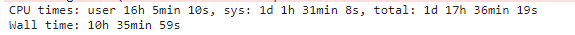

In [105]:
arima_fits = pd.read_csv("/kaggle/input/arima-fits-forecasts/fits_2.csv", index_col=0).sort_index()["0"]
arima_fits[arima_fits < 0] = 0 
arima_forecasts = pd.read_csv("/kaggle/input/arima-fits-forecasts/fore_2.csv", index_col=0).sort_index()["0"]
arima_forecasts[arima_forecasts < 0] = 0
arima_forecasts.name = "sales"
arima_forecasts.index.name = "id"

In [106]:
arima_fits.tail()

3000883     335.833953
3000884      91.242627
3000885    2097.993851
3000886     171.129376
3000887      14.547252
Name: 0, dtype: float64

In [180]:
ar_metrics = print_metrics(y_train, arima_fits)
ar_metrics

,metrics
MSLE,0.359711
MAE,57.327637


In [157]:
arima_forecasts.describe()

count    28512.000000
mean       457.680177
std       1219.628358
min          0.000000
25%          4.404982
50%         30.336651
75%        269.996135
max      15105.769365
Name: 0, dtype: float64

In [158]:
arima_forecasts.to_csv("arima_preds.csv")

In [142]:
class CombinedModel():
    
    def __init__(self):
        self.model_dicts = {}
        self.df_ = None
    
    def fit(self, df, y_train, y_lr, y_ar):
        if (df.index != y_train.index).sum() + (df.index != y_lr.index).sum() + (df.index != y_ar.index).sum() != 0:
            raise Exception("One of the indices of the df, y_train, y_lr, or y_ar does not match")
            
        dfs_ = self.preprocess(df, y_lr, y_ar, y_train, isfit=True)
        
        for label, group in dfs_:
            y = group.target
            group = group.drop(["store_nbr", "family", "target"], axis=1)
            
            model = LinearRegression().fit(group, y)
            
            self.model_dicts[label] = model
        
        return self
    
    def predict(self, df, y_lr, y_ar):
        if (df.index != y_lr.index).sum() + (df.index != y_ar.index).sum() != 0:
            raise Exception("One of the indices of the df, y_lr, or y_ar does not match")
            
        df_ = self.preprocess(df, y_lr, y_ar)
        
        preds = []
        index = []
        
        for label, group in df_:
            group = group.drop(["store_nbr", "family"], axis=1)
            
            pred = self.model_dicts[label].predict(group)
            
            preds.extend(pred)
            index.extend(group.index)
        
        res = pd.Series(preds, index=index).sort_index()
        res[res < 0] = 0
        res.name = "sales"
        res.index.name = "id"
        
        return res
        
    def preprocess(self, df, y_lr, y_ar, y_train=None, isfit=False):
         
        df_ = df[["store_nbr", "family", "onpromotion"]].copy()
        df_["y_lr"] = y_lr
        df_["y_ar"] = y_ar
        
        if isfit:
            df_["target"] = y_train
            self.df_ = df_
        
        df_groups = [(f"store_{label[0]}_family_{label[1]}",group) for label, group in df_.groupby(["store_nbr", "family"])]
        
        return df_groups
        

In [143]:
%%time
model3 = CombinedModel().fit(df, y_train, fits1, arima_fits)

CPU times: user 7.12 s, sys: 60.4 ms, total: 7.18 s
Wall time: 7.18 s


In [144]:
model3_fits = model3.predict(df, fits1, arima_fits)
model3_fits

id
0             0.000000
1             0.000000
2             0.000000
3            78.926960
4             0.000000
              ...     
3000883     442.441556
3000884     167.144819
3000885    2427.608489
3000886     118.619445
3000887      16.825587
Name: sales, Length: 3000888, dtype: float64

In [183]:
model3_metrics = print_metrics(y_train, model3_fits)
model3_metrics

,metrics
MSLE,0.208575
MAE,29.026631


In [146]:
model3_forecasts = model3.predict(test, forecasts1, arima_forecasts)
model3_forecasts.describe()

count    28512.000000
mean       450.033293
std       1209.721086
min          0.000000
25%          4.254606
50%         31.214480
75%        260.742180
max      14354.872641
Name: sales, dtype: float64

In [184]:
model3_forecasts.to_csv("arima_preds+lr_preds+onpromotion.csv")

In [148]:
class CombinedModelv2():
    
    def __init__(self):
        self.model_dicts = {}
        self.df_ = None
    
    def fit(self, df, y_train, y_lr, y_ar):
        if (df.index != y_train.index).sum() + (df.index != y_lr.index).sum() + (df.index != y_ar.index).sum() != 0:
            raise Exception("One of the indices of the df, y_train, y_lr, or y_ar does not match")
            
        dfs_ = self.preprocess(df, y_lr, y_ar, y_train, isfit=True)
        
        for label, group in dfs_:
            y = group.target
            group = group.drop(["store_nbr", "family", "target"], axis=1)
            
            model = LinearRegression().fit(group, y)
            
            self.model_dicts[label] = model
        
        return self
    
    def predict(self, df, y_lr, y_ar):
        if (df.index != y_lr.index).sum() + (df.index != y_ar.index).sum() != 0:
            raise Exception("One of the indices of the df, y_lr, or y_ar does not match")
            
        df_ = self.preprocess(df, y_lr, y_ar)
        
        preds = []
        index = []
        
        for label, group in df_:
            group = group.drop(["store_nbr", "family"], axis=1)
            
            pred = self.model_dicts[label].predict(group)
            
            preds.extend(pred)
            index.extend(group.index)
        
        res = pd.Series(preds, index=index).sort_index()
        res[res < 0] = 0
        res.name = "sales"
        res.index.name = "id"
        
        return res
        
    def preprocess(self, df, y_lr, y_ar, y_train=None, isfit=False):
         
        df_ = df[["store_nbr", "family", "onpromotion"]].copy()
        #df_["y_lr"] = y_lr
        df_["y_ar"] = y_ar
        
        if isfit:
            df_["target"] = y_train
            self.df_ = df_
        
        df_groups = [(f"store_{label[0]}_family_{label[1]}",group) for label, group in df_.groupby(["store_nbr", "family"])]
        
        return df_groups

In [149]:
%%time
model4 = CombinedModelv2().fit(df, y_train, fits1, arima_fits)

CPU times: user 6.88 s, sys: 38.8 ms, total: 6.92 s
Wall time: 6.92 s


In [150]:
model4_fits = model4.predict(df, fits1, arima_fits)
model4_fits

id
0             1.599062
1             0.000000
2             1.353704
3           157.863523
4             0.027271
              ...     
3000883     361.468233
3000884      91.474004
3000885    2117.999006
3000886     160.377347
3000887      15.020312
Name: sales, Length: 3000888, dtype: float64

In [186]:
model4_metrics = print_metrics(y_train, model4_fits)
model4_metrics

,metrics
MSLE,0.666349
MAE,57.715889


In [155]:
model4_forecasts = model4.predict(test, forecasts1, arima_forecasts)
model4_forecasts.to_csv("arima_preds+onpromotion.csv")
model4_forecasts.describe()

count    28512.000000
mean       456.941499
std       1213.577084
min          0.000000
25%          4.263230
50%         30.684616
75%        272.202874
max      14364.528683
Name: sales, dtype: float64

In [159]:
class Modelv2():
    
    def __init__(self):
        self.model_dict1 = {}
        self.model_dict2 = {}
        self.feats_dict = {}
        self.encoder = None
        self.df_ = None
        self.start_date = None
    
    def fit(self, df, holidays, transaction_df, y):
        self.start_date = df.date[0]
        
        df_ = self.df_constructor(df, holidays, transaction_df=transaction_df)
        df_ = self.encode_feats(df_, fit_only=True)
        self.df_ = df_
        
        df_groups = self.group_df(df, df_)
        
        for label, group in df_groups:
            group = group.drop(["store_nbr", "family"], axis=1)
            group_sum = group.sum()
            
            self.feats_dict[label] = group_sum.index[group_sum != 0]
            
            model_1 = LinearRegression()
            model_1.fit(group[self.feats_dict[label]], y.loc[group.index])
            
            preds = pd.Series(model_1.predict(group[self.feats_dict[label]])).apply(self.max_f).to_numpy()
            
            resid = y.loc[group.index] - preds
            
            model_2 = XGBRegressor(n_estimators=50, max_depth=5)
            model_2.fit(group[self.feats_dict[label]], resid)
            
            self.model_dict1[label] = model_1
            self.model_dict2[label] = model_2
        
        return self
    
    def predict(self, df, holidays, transaction_df):

        df_ = self.df_constructor(df, holidays, transaction_df=transaction_df)
        df_ = self.encode_feats(df_)
        
        df_groups = self.group_df(df, df_)
        
        preds = []
        idx = []
        
        for label, group in df_groups:
            group = group.drop(["store_nbr", "family"], axis=1)
            
            pred_ = self.model_dict1[label].predict(group[self.feats_dict[label]])
            pred_ = pd.Series(pred_).apply(self.max_f).to_numpy() + self.model_dict2[label].predict(group[self.feats_dict[label]])

            preds.extend(pred_)
            idx.extend(group.index)
            
        res = pd.Series(preds, index=idx)
        res = res.sort_index()
        res = res.apply(self.max_f)
        
        return res
    
    def max_f(self, x):
        return max(0.0, x)
    
    def group_df(self, df, df_):
        df_["store_nbr"] = df.store_nbr
        df_["family"] = df.family
        
        df_groups = [(f"store_{label[0]}_{label[1]}",group) for (label, group) in df_.groupby(["store_nbr", "family"])]
       
        return df_groups
    
    
    def encode_feats(self, df, fit_only=False, cat_feats=None):
        df_ = pd.DataFrame(df[["type", "locale", "locale_name", "transferred"]])
        df_ = self.add_synthetic_feats(df, df_)
        
        if cat_feats is None:
            cat_feats = ["type", "locale", "locale_name", "transferred",
                        "day", "month", "day_of_month"]
        
        if fit_only:
            self.encoder = OneHotEncoder(sparse_output=False, drop="first")
            self.encoder = self.encoder.fit(df_[cat_feats])
            
        df_ = pd.DataFrame(self.encoder.transform(df_[cat_feats]),
                              index=df.index,
                              columns=self.encoder.get_feature_names_out())
        
        df_["transactions"] = df.transactions
        df_["onpromotion"] = df.onpromotion
        df_["arima_preds"] = df.arima_preds
        
        trend = (df.date - self.start_date).dt.days
        df_["trend"] = trend
        
        date_range = pd.date_range(start="2016-04-16", freq="D", periods=30)
        quake_indicator = df.date.isin(date_range)
        df_["quake_indicator"] = quake_indicator
        
        df_.index = df.index
        
        return df_
    
    def add_synthetic_feats(self, df, df_):
        df_["day"] = df.date.dt.dayofweek
        df_["month"] = df.date.dt.month
        
        day_of_month = pd.Series(np.zeros(len(df)), index=df.index)
        idx = df.date.dt.day.isin([15, 16, 17, 18, 30, 31, 1, 2, 3])
        day_of_month[idx] = 1
        df_["day_of_month"] = day_of_month
        
        df_.index = df.index
        
        return df_
    
    def df_constructor(self, df, holidays, transaction_df, oil=None, holiday_feats=None):
        #Holiday feats
        if holiday_feats is None:
            holiday_feats = ["date", "type", "locale", "locale_name", "transferred"]
            
        holidays = holidays[holiday_feats]
        holidays = holidays.drop_duplicates(subset="date")

        res_df = df.merge(holidays, how="left", on="date")
        res_df = res_df.fillna("normal")
        res_df.transferred = res_df.transferred.apply(str)
        
        #transaction_df
        res_df["identifier"] = res_df.store_nbr.apply("str") + "_" + res_df.date.apply(str)
        transaction_df = transaction_df[["identifier", "transactions"]]
        
        res_df = res_df.merge(transaction_df, on="identifier", how="left")
        res_df.transactions = res_df.transactions.fillna(0)
        res_df.pop("identifier")
        
        res_df.index = df.index
        
        return res_df

In [161]:
df_augmented = df.copy()
df_augmented["arima_preds"] = arima_fits
df_augmented

,date,store_nbr,family,onpromotion,arima_preds
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0,0.000000
1,2013-01-01,1,BABY CARE,0,0.000000
2,2013-01-01,1,BEAUTY,0,0.000000
3,2013-01-01,1,BEVERAGES,0,0.000000
4,2013-01-01,1,BOOKS,0,0.000000
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,0,335.833953
3000884,2017-08-15,9,PREPARED FOODS,1,91.242627
3000885,2017-08-15,9,PRODUCE,148,2097.993851


In [165]:
%%time
model5 = Modelv2().fit(df_augmented, holidays_df, transaction_df, y_train)

CPU times: user 28min 55s, sys: 5min 57s, total: 34min 53s
Wall time: 9min 31s


In [187]:
model5_fits = model5.predict(df_augmented, holidays_df, transaction_df)
model5_metrics = print_metrics(y_train, model5_fits)
model5_metrics

,metrics
MSLE,0.230843
MAE,27.251511


In [169]:
test_augmented = test.copy()
test_augmented["arima_preds"] = arima_forecasts
test_augmented

,date,store_nbr,family,onpromotion,arima_preds
id,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,4.988978
3000889,2017-08-16,1,BABY CARE,0,0.000000
3000890,2017-08-16,1,BEAUTY,2,6.581011
3000891,2017-08-16,1,BEVERAGES,20,2141.892784
3000892,2017-08-16,1,BOOKS,0,0.062819
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,349.956045
3029396,2017-08-31,9,PREPARED FOODS,0,93.161641
3029397,2017-08-31,9,PRODUCE,1,1098.620128


In [175]:
model5_forecasts = model5.predict(test_augmented, holidays_df, transaction_df)
model5_forecasts.name = "sales"
model5_forecasts.index.name = "id"
model5_forecasts

id
3000888    2.848199e+00
3000889    9.107392e-09
3000890    8.727224e+00
3000891    2.486560e+03
3000892    4.467724e-02
               ...     
3029395    3.378797e+02
3029396    1.121607e+02
3029397    1.331302e+03
3029398    2.031336e+02
3029399    1.695970e+01
Name: sales, Length: 28512, dtype: float64

In [176]:
model5_forecasts.to_csv("model1+arima_preds.csv")

# Model Performance Summary

In [214]:
model1 = ["model 1", "Linear Regression Model with trend, holidays, and seasonality features", metrics1.loc["MSLE"].item(), metrics1.loc["MAE"].item(), 0.49834]
model2 = ["model 2", "AR model (6,0,0)(4,1,0,7)", ar_metrics.loc["MSLE"].item(), ar_metrics.loc["MAE"].item(), 0.46698]
model3 = ["model 3", "Linear Regression using the predictions of model 1 and model 2 as regressors", model3_metrics.loc["MSLE"].item(), model3_metrics.loc["MAE"].item(), 0.5528]
model4 = ["model 4", "Linear Regression using predictions from model 2 and onpromotion as regressors", model4_metrics.loc["MSLE"].item(), model4_metrics.loc["MAE"].item(), 0.44649]
model5 = ["model 5", "Model 1 with the prediction from model 2 added as another regressor", model5_metrics.loc["MSLE"].item(), model5_metrics.loc["MAE"].item(), 0.49461]

pd.set_option('display.max_colwidth', None)
df_res = pd.DataFrame([model1, model2, model3, model4, model5],columns=["model", "description", "insample MSLE", "insample MAE", "submission score"])
df_res.index = df_res.pop("model")
df_res.sort_values(by="submission score")

,description,insample MSLE,insample MAE,submission score
model,,,,
model 4,Linear Regression using predictions from model 2 and onpromotion as regressors,0.666349,57.715889,0.44649
model 2,"AR model (6,0,0)(4,1,0,7)",0.359711,57.327637,0.46698
model 5,Model 1 with the prediction from model 2 added as another regressor,0.230843,27.251511,0.49461
model 1,"Linear Regression Model with trend, holidays, and seasonality features",0.290016,29.885583,0.49834
model 3,Linear Regression using the predictions of model 1 and model 2 as regressors,0.208575,29.026631,0.55280


### Leaderboard rank of the best model 72/673

Citation : Alexis Cook, DanB, inversion, Ryan Holbrook. (2021). Store Sales - Time Series Forecasting. Kaggle. https://kaggle.com/competitions/store-sales-time-series-forecasting